# Imports/utility functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gc, os, cna, warnings
import scanpy as sc
import vima.data.samples as vds
import vima.data.patchcollection as vdp
import vima.vis as vv
from PIL import Image
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
fs_axislabel = 10
fs_figsubpanel = 14
fs_legend = 8

# Prepare

## read data

In [2]:
d = cna.read('_results/default-vae.h5ad'); d.sampleid = 'sid'
davg = cna.read('_results/patchwideavgs.h5ad'); davg.sampleid = 'sid'
davg_noharm = cna.read('_results/patchwideavgs_nonharmpixels.h5ad'); davg_noharm.sampleid = 'sid'

In [3]:
patchsize = 40; patchstride = 10

# read in samples
def fname_parser(fname):
    fname = fname.split('/')[-1].split('.nc')[0]
    return {
        'donor': fname.split('_')[0].replace('Repeat',''),
        'sid': fname
    }
repname = 'pca_k=5_harmony'
samples = vds.read_samples(f'../../RA/BHAM-data/10u/{repname}/*.nc', fname_parser)

P = vdp.PatchCollection(
    vds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.8),
                        samples, standardize=True)
sid_nums = {sid:sid_num for sid, sid_num in P.meta[['sid','sid_num']].drop_duplicates().values}

# choose which patches to do case/ctrl analysis on
Pdense = vdp.PatchCollection(
    vds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.2),
                        samples, sid_nums=sid_nums, standardize=True)

100%|███████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.17it/s]


in pytorch mode
means: [-0.05243582 -0.03230326 -0.00229286 -0.02602134  0.00177602]
stds: [0.79012054 0.78177357 0.7567832  0.52874565 0.39269742]
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.59it/s]


in pytorch mode
means: [-0.01986346  0.01847187  0.16045739  0.01280895  0.03556424]
stds: [1.003166   1.0234437  0.97412163 0.68461114 0.53847617]
data augmentation is off


## colormaps

In [4]:
# read in samples
def fname_parser(fname):
    fname = fname.split('/')[-1].split('.nc')[0]
    return {
        'donor': fname.split('_')[0].replace('Repeat',''),
        'sid': fname
    }
samples_m = vds.read_samples(f'../../RA/BHAM-data/10u/normalized/*.nc', fname_parser)
patchsize = 40; patchstride = 10
M = vdp.PatchCollection(
    vds.choose_patches(samples_m, patchsize, patchstride, max_frac_empty=0.8),
                        samples_m, standardize=True)
Mdense = vdp.PatchCollection(
    vds.choose_patches(samples_m, patchsize, patchstride, max_frac_empty=0.2),
                        samples_m, standardize=True)
markers = list(list(samples_m.values())[0].marker.values)
gc.collect()

100%|███████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.15it/s]


in pytorch mode
means: [ 0.00793673 -0.01663893  0.01270433 -0.0013747   0.00480762  0.01947449
 -0.00018515]
stds: [0.71805185 0.7177401  0.73233104 0.72275585 0.7207492  0.7152629
 0.7093583 ]
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.07it/s]


in pytorch mode
means: [ 0.11101544 -0.22449353  0.04531196 -0.01259627  0.08451226  0.19895115
  0.05391984]
stds: [0.9417427  0.84677875 0.88562727 0.9047441  0.92348    0.99722487
 0.9068408 ]
data augmentation is off


0

data augmentation is off
in numpy mode
data augmentation is off
in numpy mode


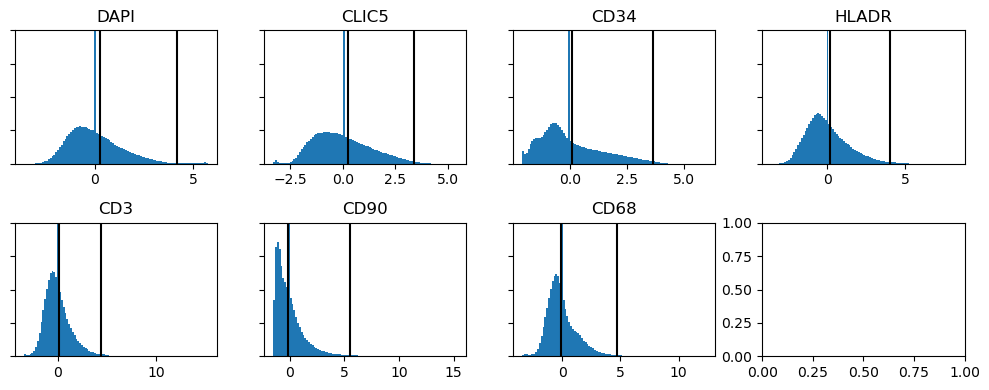

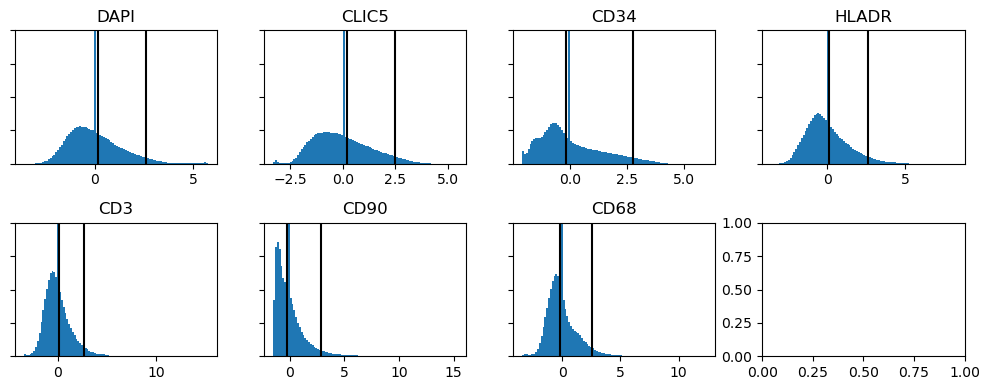

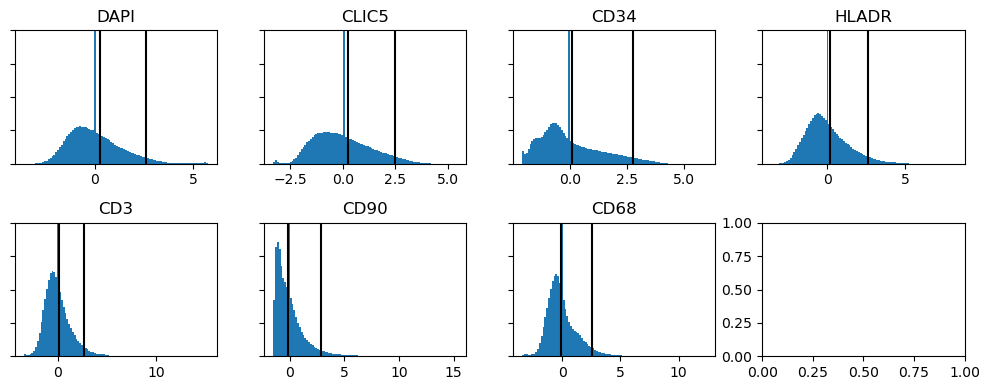

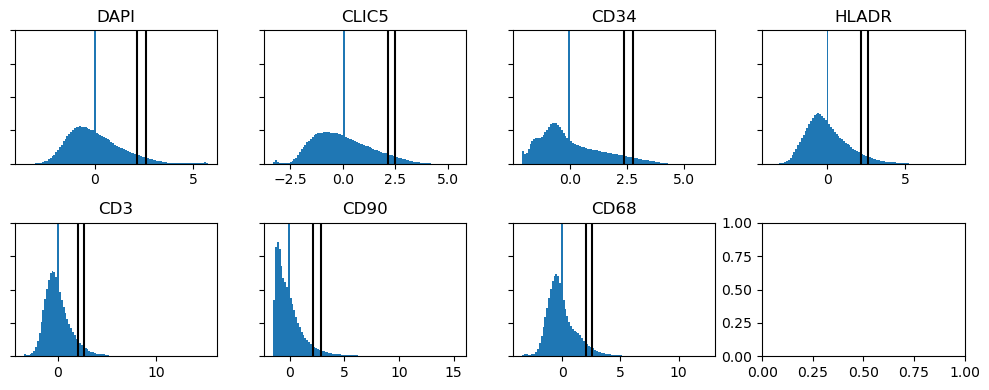

In [5]:
# make histogram of all markers
from scipy import stats
def make_hists(pixels, threshs=[60,99]):
    fig, axs = plt.subplots(2,4,figsize=(10,4))
    percentiles = {}
    for i, ax in zip(range(len(markers)), axs.flatten()):
        nums = pixels[:,:,:,i].flatten()
        [a, b] = np.percentile(nums[(nums-stats.mode(nums)[0])**2 > 0.01], threshs)
        percentiles[markers[i]] = [a,b]
        ax.hist(nums, bins=100)
        ax.set_title(markers[i]); ax.set_yticklabels([]); ax.set_ylim(0,400000)
        ax.axvline(a, color='k'); ax.axvline(b, color='k')
    plt.tight_layout(); plt.show()
    return percentiles

# use histograms of each marker to define scaling functions used to determine color intensities
M.numpy_mode()
Mdense.numpy_mode()
raw_percentiles = make_hists(M[::10][0])
raw_percentiles['DAPI'] = make_hists(M[::10][0], threshs=[58,95])['DAPI']
raw_percentiles['CD90'] = make_hists(M[::10][0], threshs=[60,95])['CD90']
raw_percentiles['CD68'] = make_hists(M[::10][0], threshs=[92,95])['CD90']
raw_scalers = {
    m : vv.scaler(raw_percentiles[m][0],raw_percentiles[m][1])
    for m in markers}

In [6]:
# define colormaps
fibro_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['CD34', 'CD90', 'CLIC5', 'DAPI'],
                    np.array([[1,0,0],[0.6,0.6,0.6],[1,1,0],[0,0.5,1]])*\
                    np.array([[1],[1],[1],[1]]))]
immune_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['HLADR', 'CD90', 'CD3', 'CD68', 'DAPI'],
                    np.array([[1,0,0],[0.8,0.8,0.8],[0,1,0],[0.5,0,0.5],[0,0,0]])*\
                    np.array([[1],[1],[1],[1],[1]]))]
fibrot_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['CD34', 'CD90', 'CD68', 'DAPI','CD3'],
                    np.array([[1,0,0],[0.6,0.6,0.6],[1,0,1],[0,0.5,1],[0,1,0]])*\
                    np.array([[0],[1],[1],[1],[1]]))]
fibrocd3_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['CD34', 'CD90', 'CLIC5', 'DAPI','CD3'],
                    np.array([[1,0,0],[0.6,0.6,0.6],[1,1,0],[0,0.5,1],[0,1,0]])*\
                    np.array([[1],[1],[1],[1],[0.7]]))]
fibroclict_cmap = [
    [markers.index(m), c, raw_scalers[m]]
    for m, c in zip(['CD34', 'CD90', 'CLIC5', 'DAPI','CD3','HLADR'],
                    np.array([[1,0,0],[0.6,0.6,0.6],[1,1,0],[0,0.5,1],[0,1,0],[0,1,1]])*\
                    np.array([[1],[1],[1],[1],[1],[1]]))]

# Overview figure

In [7]:
import torch
from vima.models.resnet_vae import ResnetVAE
model = ResnetVAE(len(P.meta.sid.unique()), network='light', mode='advanced', ncolors=Pdense.nchannels, nlatent=100)
model.load_state_dict(torch.load(f'_results/default-vae.pt'))

<All keys matched successfully>

In [8]:
def plot_patchreconstructions(fig, pid, left, bottom, width, height):
    model.eval()
    with torch.no_grad():
        patchwidth = width / 5
        p = Pdense[pid][0].detach().cpu().numpy()
        reconst = model(Pdense[pid:pid+1])[0][0].detach().cpu().numpy()

        for j in range(5):
            ax_orig = fig.add_axes([left + j*patchwidth, bottom + height/2, patchwidth * 0.95, height / 2])
            ax_orig.imshow(p[j], cmap='seismic', vmin=P.vmin[0], vmax=P.vmax[0])
            ax_orig.spines[:].set_visible(False); ax_orig.set_xticks([]); ax_orig.set_yticks([])
            
            ax_recon = fig.add_axes([left + j*patchwidth, bottom, patchwidth * 0.95, height / 2])
            ax_recon.imshow(reconst[j], cmap='seismic', vmin=P.vmin[0], vmax=P.vmax[0])
            ax_recon.spines[:].set_visible(False); ax_recon.set_xticks([]); ax_recon.set_yticks([])

            fig.text(left + j*patchwidth + patchwidth*0.95/2, bottom + height/2, f'MM{j+1}',
                     ha='center', va='center', fontsize=fs_axislabel)

            if j == 0:
                ax_orig.set_ylabel('Original', fontsize=fs_axislabel)
                ax_recon.set_ylabel(' Reconstruction', fontsize=fs_axislabel)
            if j == 4:
                scalebar = AnchoredSizeBar(ax_recon.transData,
                    10, '', 'lower right', pad=0.2, label_top=True, color='black', frameon=False, size_vertical=1.3,)
                ax_recon.add_artist(scalebar)

In [9]:
from scipy.stats import entropy
def plot_isi(ax):
    def get_isi(D):
        NAM = D.uns['NAM.T'].T.values.copy()
        NAM /= NAM.sum(axis=0)
        return np.power(2, entropy(NAM, axis=0) / np.log(2))
    bins = np.arange(0,25,0.5)
    dres = ax.hist(get_isi(d), bins=bins, alpha=0.5, label='VIMA')
    davgres = ax.hist(get_isi(davg), bins=bins, alpha=0.5, label='Patch avg. (integrated pixels)')
    davg_noharmres = ax.hist(get_isi(davg_noharm), bins=bins, alpha=0.5, label='Patch avg. (non-integrated pixels)')
    ax.set_xticks([1,5,10,15,20,25])
    ax.set_xlim(1,25)
    ax.set_xlabel('Sample integration (perplexity over samples)', fontsize=fs_axislabel)
    ax.set_ylabel('#Microniches (log-scale)', fontsize=fs_axislabel)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y):,}"))

    for D, res, c in [(d, dres, 'blue'), (davg, davgres, 'orange'), (davg_noharm, davg_noharmres, 'green')]:
        med = np.median(get_isi(D))
        print(f'{c} median perplexity is {med}')
        if c == 'blue': vima_med = med
        medy = res[0][np.where(res[1] >= med)[0][0]-1]
        ax.plot([med, med], [0, 0.95*medy], color=c, lw=2)
    
    ax.annotate(
        'uniform over\n~16 samples',
        xy=(vima_med, 200),  # Ending point
        xytext=(7, 800),  # Starting point
        color='blue',
        arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle='->', lw=1)
    )
    ax.legend(fontsize=fs_legend)
    ax.spines[['right','top']].set_visible(False)

In [10]:
from matplotlib.patches import ConnectionPatch
def line(x1, y1, ax, x2, y2, fig):
    line = ConnectionPatch(
        (x1, y1), (x2, y2),
        coordsA="data",
        coordsB="figure fraction",
        axesA=ax,
        axesB=None,
        color="black", linewidth=0.5, linestyle="-"
    )
    fig.add_artist(line)

from io import BytesIO
def make_pics(patchids, mn_pics):
    s = np.zeros((len(d), len(patchids)))
    for i, j in enumerate(patchids):
        s[j, i] = 1
    mns = cna.tl.diffuse(d, s, 3)
    for patchid, mn in zip(patchids, mns.T):
        thresh = sorted(mn)[::-1][np.where(np.cumsum(sorted(mn)[::-1]) > 0.7)[0][0]]
        d.obs[f'mn_{patchid}'] = mn * (mn > thresh)
        np.random.seed(0)
        idx = np.random.choice(len(mn), size=9, p=mn/mn.sum())
        vv.plot_patches_overlaychannels_linsum(
                    Mdense[idx][0],
                    d.X[idx],
                    cmap,
                    nx=3, ny=3,
                    show=False
                )
        plt.gcf().patch.set_facecolor('black')
        mn_pics[patchid] = BytesIO()
        plt.savefig(mn_pics[patchid], format="png", bbox_inches="tight", dpi=800)
        mn_pics[patchid].seek(0)
        plt.close()

from PIL import Image
def plot_mn(ax, patchid, x, y):
    cc = d.obsm['X_umap'][patchid]
    line(cc[0], cc[1], ax, x+insetsize/2, y+ar*insetsize/2, fig)
    sc.pl.umap(d[d.obs[f'mn_{patchid}'] > 0], color=f'mn_{patchid}', s=15,
               colorbar_loc=None, title='',
               cmap='Greens', ax=ax, frameon=False, show=False)
    ax = fig.add_axes([x, y, insetsize, ar*insetsize], zorder=1000)
    ax.imshow(Image.open(mn_pics[patchid]))
    ax.axis('off')

from matplotlib.patches import Rectangle
def color_legend(ax, x=0.02, line_height=0.2, fontsize=16):
    rectangle = Rectangle(
        (0, 0), 1, 1, color='black', zorder=2
    )
    ax.add_patch(rectangle)

    items = [(markers[color[0]], color[1]) for color in fibro_cmap]
    for i, (line, color) in enumerate(items):
        ax.text(
            line_height/8,
            1- i * line_height - line_height/8,
            line,
            color=color,
            fontsize=fontsize,
            fontweight='medium',
            va='top',  # Vertical alignment
            ha='left',  # Horizontal alignment
            zorder=3
        )
    ax.axis('off')

blue median perplexity is 15.667103269672989
orange median perplexity is 3.809615262644543
green median perplexity is 1.2497066170464333


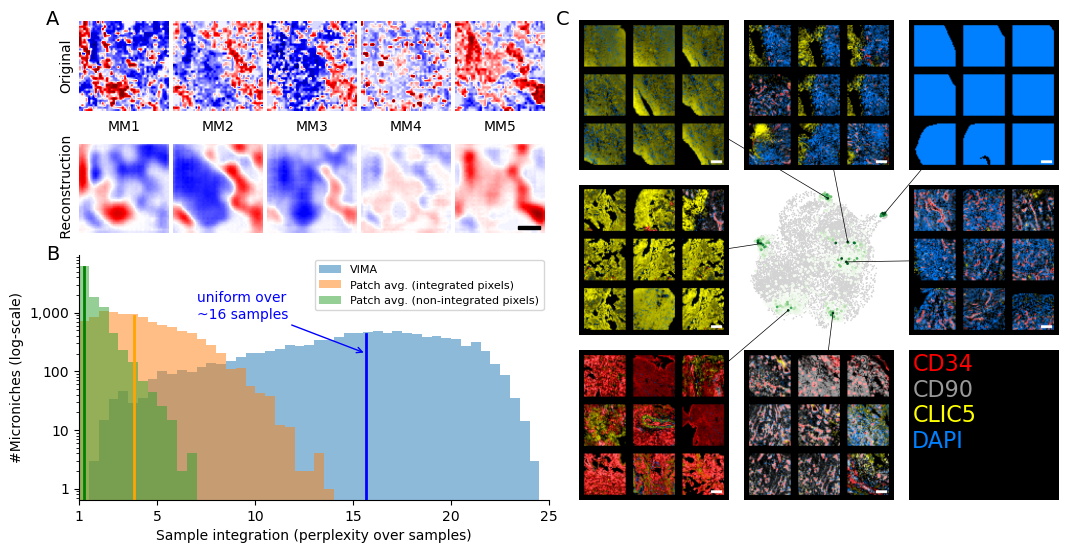

In [44]:
# figure size parameters
figsize = (10,5); ar = figsize[0]/figsize[1]
fig = plt.figure(figsize=figsize)
mn_image_locations = [
    (0.5,0.33),
    (0.5,0),
    (0.5+0.33/2,0),
    (0.5+0.66/2,0.33),
    (0.5+0.66/2,0.66),
    (0.5+0.33/2,0.66),
    (0.5,0.66),
]
insetsize = 0.15

# plotting choices
patchids = [4755, 9898, 2193, 6857, 1522, 8008, 10322] #backup examples: 1107 (DAPI only)
nx = ny = 3
cmap = fibro_cmap

## patch reconstructions
plot_patchreconstructions(fig, 3500, 0, 0.5, 0.47, 0.49) # backup examples: 500, 6649, 4526

## entropy histogram
plot_isi(fig.add_axes([0, 0, 0.47, 0.49]))

## examples of microniches
mn_pics = {}
make_pics(patchids, mn_pics)
umapax = fig.add_axes([0.5+0.33/2, 0.33, 0.3/2, 0.3])
sc.pl.umap(d, ax=umapax, frameon=False, show=False, s=5)
for i, (patchid, (x,y)) in enumerate(zip(patchids, mn_image_locations)):
    plot_mn(umapax, patchid, x, y)
color_legend(fig.add_axes([0.5+0.66/2, 0, insetsize, ar*insetsize]), line_height=0.17)

# subpart labels
fig.text(-0.02, 0.98, 'A', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(-0.02, 0.51, 'B', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.49, 0.98, 'C', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')

fig.savefig('../_main/fig.RAoverview.pdf', bbox_inches='tight', dpi=800)
fig.savefig('../_main/fig.RAoverview.png', bbox_inches='tight', dpi=500)
plt.show()

# Case-control analysis

In [13]:
def mam_pcs(ax):
    pcs = d.uns['NAM_sampleXpc']
    ax.scatter(pcs[d.samplem.fstar].PC1, pcs[d.samplem.fstar].PC2, color='red', label='F/TF/EFM', alpha=0.7)
    ax.scatter(pcs[~d.samplem.fstar].PC1, pcs[~d.samplem.fstar].PC2, color='blue', label='M/TM/TB', alpha=0.7)
    ax.legend(fontsize=fs_legend)
    ax.set_xticks([-0.4, 0, 0.4])
    ax.set_yticks([-0.4, 0, 0.4])
    ax.set_xlabel('MAM-PC1', fontsize=fs_axislabel)
    ax.set_ylabel('MAM-PC2', fontsize=fs_axislabel)
    ax.spines[['right', 'top']].set_visible(False)

def small_color_legend(ax, cmap, x=0.05, line_height=0.15, fontsize=16):
    rectangle = Rectangle(
        (0, 0), 1, 1, color='black', zorder=2
    )
    ax.add_patch(rectangle)

    items = [(markers[color[0]], color[1]) for color in cmap]
    for i, (line, color) in enumerate(items):
        ax.text(
            line_height/3,
            1- i * line_height - line_height/3,
            line,
            color=color,
            fontsize=fontsize,
            fontweight='medium',
            va='top',
            ha='left',
            zorder=3
        )
    ax.axis('off')

def get_or(totals, name, ctaporder):
    others = [c for c in totals.columns if c != name]
    oddsratios = pd.Series()
    ses = pd.Series()
    for ctap in totals.index:
        odds = totals.loc[ctap, name] / totals.loc[ctap, others].sum()
        ref = totals.loc[totals.index != ctap].sum(axis=0)
        ref_odds = ref[name] / ref[others].sum()
        ses.loc[ctap] = np.sqrt((1/totals.loc[ctap]).sum() + (1/ref).sum()) / np.log(2)
        oddsratios.loc[ctap] = odds / ref_odds
    for c in ctaporder:
        if c not in oddsratios.index:
            oddsratios.loc[c] = np.nan
            ses.loc[c] = np.nan
    return np.log2(oddsratios), ses

def enrichment(ax, posneg, name, yticks, clustlabel, minpatches=50, ctaporder=['M','TM','TB']):
    myclusts = [c for c in d.samplem.columns if c.startswith(posneg)]
    totals = d.samplem[['CTAP'] + myclusts].groupby('CTAP').aggregate('sum')
    totals.index = totals.index.str.replace(' + ', '')
    totals = totals.loc[totals.sum(axis=1) > minpatches]
    lors, ses = get_or(totals, name, ctaporder)
    print(f'\nlog odds ratios for cluster {clustlabel} within {posneg} patches')
    results = pd.DataFrame({'LOR':lors, 'CI_lower':lors - 2*ses, 'CI_upper':lors + 2*ses})
    print(results)
    lors.loc[ctaporder].plot(kind='bar', color='teal', yerr=2*ses.loc[ctaporder], ax=ax)
    ax.axhline(y=0, ls='-', color='black')
    ax.set_ylabel(f'logOR(clust. {clustlabel} vs {clustlabel+1})')
    ax.set_xlabel('Disease subtype')
    ax.set_yticks(yticks)
    ax.tick_params(axis='x', rotation=0)

from matplotlib.patheffects import withStroke
def umap(ax, title=''):
    sc.pl.umap(d, ax=ax, show=False, s=5)
    sc.pl.umap(d[d.obs.ncorr_thresh != 0], color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1, s=10, ax=ax, show=False,
               colorbar_loc=None, frameon=False, title=title)

    p = 0.0006599934000659993
    formatted = f"${p:.1e}"
    formatted_latex = formatted.replace('-0', '-').replace("e", r" \times 10^{").replace("+", "").replace("-", r"-") + "}$"
    ax.text(-4, -1, f'P={formatted_latex}', ha='left', va='bottom', fontsize=fs_legend, fontweight='medium')
    
    fontprops = {'fontsize':fs_axislabel, 'fontweight':'bold', 'color':'black', 'ha':'center', 'va':'center'}
    for i, cond in enumerate([d.obs.neg_leiden == '1', d.obs.neg_leiden == '0', d.obs.pos_leiden == '0', d.obs.pos_leiden == '1']):
        text = ax.text(*np.median(d.obsm['X_umap'][cond], axis=0), str(i+1), **fontprops)
        text.set_path_effects([withStroke(linewidth=3, foreground='white')])

def volcano(ax, resultsfile='_results/patchfingerprints_clustertest.csv'):
    ttest = pd.read_csv(resultsfile)
    ax.scatter(ttest.stat, -np.log10(ttest.p), alpha=0.7)
    ax.axhline(y=-np.log10(0.05/len(ttest)), ls='--', color='gray')
    ax.axvline(x=0, ls='-', color='black')
    ax.set_xticks([-0.6, 0, 0.6])
    ax.set_yticks([0,1,2,3])
    ax.set_xlabel('Corr. to case status', fontsize=fs_axislabel)
    ax.set_ylabel('$-\\log_{10}(P)$', fontsize=fs_axislabel)
    ax.spines[['right', 'top']].set_visible(False)

def clust_examples(ax, mask, cmap, label, nx=3, ny=3, seed=0):
    np.random.seed(seed)
    idx = np.random.choice(np.where(mask)[0], size=nx*ny, replace=False)
    fig = vv.plot_patches_overlaychannels_linsum(
                Mdense[idx][0],
                d.X[idx],
                cmap,
                nx=nx, ny=ny,
                show=False
            )
    fig.patch.set_facecolor('black')
    buff = BytesIO()
    fig.savefig(buff, format="png", bbox_inches="tight", dpi=800)
    plt.close(fig)
    buff.seek(0)
    ax.imshow(Image.open(buff))
    text = ax.text(100, 100, label, fontsize=fs_axislabel, color='black', ha='left', va='top')
    text.set_path_effects([withStroke(linewidth=3, foreground='white')])

    ax.axis('off')

from io import BytesIO
from PIL import Image
from importlib import reload; reload(vv)
def spatialplot(ax, ncols, sids):
    sortkey = pd.Series(range(len(sids)), index=sids)
    fig = vv.spatialplot({sid:s for sid,s in samples.items() if sid in sids},
                   sortkey,
                   d.obs,
                   [d.obs.ncorr_thresh > 0, d.obs.ncorr_thresh < 0],
                   labels=d.samplem.CTAP.str.replace(' + ', ''),
                   rgbs=[[1,0,0],[0, 0, 1]],
                   skipthresh=50, filterempty=True,
                   vmax=1.5, ncols=ncols, size=2, show=False)
    buff = BytesIO()
    fig.savefig(buff, format="png", bbox_inches="tight", dpi=800)
    plt.close(fig)
    buff.seek(0)
    ax.imshow(Image.open(buff))
    ax.axis('off')

......
log odds ratios for cluster 1 within neg patches
         LOR  CI_lower  CI_upper
M   0.928362  0.661058  1.195666
TB -0.094904 -0.382459  0.192652
TM -1.588581 -1.984718 -1.192444

log odds ratios for cluster 3 within pos patches
          LOR  CI_lower  CI_upper
EFM  0.517244  0.140192  0.894296
F   -0.015487 -0.325318  0.294344
M    1.373117  0.840938  1.905297
TB   0.208068 -0.250642  0.666778
TF  -0.606967 -0.948937 -0.264997
TM  -2.349322 -3.331905 -1.366739


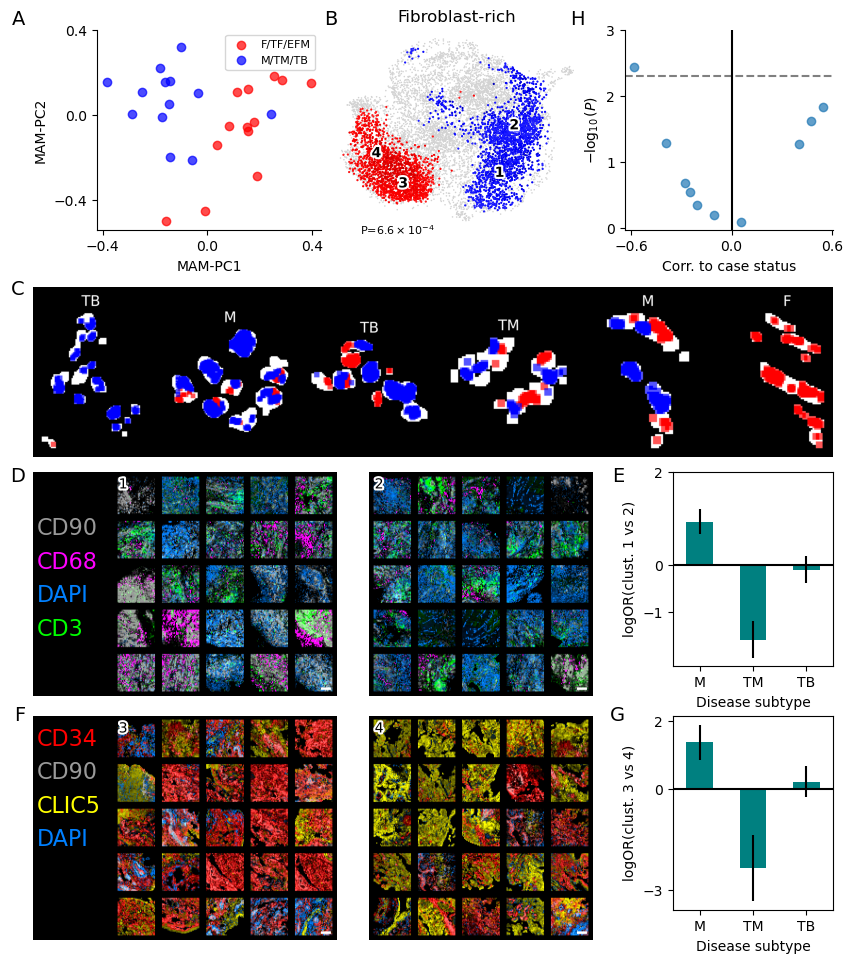

In [21]:
figsize = (8,10); ar = figsize[0]/figsize[1]
insetw = 0.28
nx = ny = 5
fig = plt.figure(figsize=figsize)

mam_pcs(fig.add_axes([0.08, 0.8, 0.28, 0.2]))
umap(fig.add_axes([0.37, 0.8, 0.32, 0.2]), title='Fibroblast-rich')
volcano(fig.add_axes([0.74, 0.8, 0.26, 0.2]))

spatialplot(fig.add_axes([0, 2*ar*insetw+0.085, 1, 0.25]), 6,
            ['300-1933_Scan2', '300-1879_Scan1', '300-0491_Scan1','300-0501_Scan1',
                  '300-0307_Scan1', '300-0251Repeat_Scan1'])
            # old examples: ['300-1933_Scan2', '300-0491_Scan1','300-0501_Scan1',
            #       '300-0504_Scan1', '300-0310_Scan2', '300-0251Repeat_Scan1'])

clust_examples(fig.add_axes([0.1, ar*insetw+0.11, insetw, ar*insetw]), d.obs.neg_leiden == '1', fibrot_cmap, '1', nx=nx, ny=ny)
clust_examples(fig.add_axes([0.42, ar*insetw+0.11, insetw, ar*insetw]), d.obs.neg_leiden == '0', fibrot_cmap, '2', nx=nx, ny=ny)
enrichment(fig.add_axes([0.8, ar*insetw+0.11+0.03, 0.2, ar*insetw-0.03]), 'neg', 'neg1', [-1,0,2], 1)
small_color_legend(fig.add_axes([0, ar*insetw+0.11, 0.1, ar*insetw]), fibrot_cmap)

clust_examples(fig.add_axes([0.1, 0.09, insetw, ar*insetw]), d.obs.pos_leiden == '0', fibro_cmap, '3', nx=nx, ny=ny)
clust_examples(fig.add_axes([0.42, 0.09, insetw, ar*insetw]), d.obs.pos_leiden == '1', fibro_cmap, '4', nx=nx, ny=ny)
enrichment(fig.add_axes([0.8, 0.09+0.03, 0.2, ar*insetw-0.03]), 'pos', 'pos0', [-3,0,2], 3)
small_color_legend(fig.add_axes([0, 0.09, 0.1, ar*insetw]), fibro_cmap)


# subpart labels
fig.text(-0.01, 1.02, 'A', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.38, 1.02, 'B', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.69, 1.02, 'H', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(-0.01, 0.75, 'C', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(-0.01, 2*ar*insetw+0.115, 'D', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.74, 2*ar*insetw+0.115, 'E', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(-0.01, ar*insetw+0.1, 'F', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')
fig.text(0.74, ar*insetw+0.1, 'G', fontsize=fs_figsubpanel, fontweight='medium', va='top', ha='right')

fig.savefig('../_main/fig.RAcc.pdf', bbox_inches='tight', dpi=800)
fig.savefig('../_main/fig.RAcc.png', bbox_inches='tight', dpi=500)
plt.show()

# Supp

## marker list

In [78]:
df = pd.DataFrame(data={'Marker':markers})
df['Comments'] = ['nuclear stain',
                  'lining fibroblasts',
                  'sublining fibroblasts, endothelial cells',
                  'antigen presentation',
                  'T cells',
                  'sublining fibroblasts, pericytes',
                  'macrophages']
df[''] = ''
df.style.hide() \
    .map_index(lambda v: "font-weight: bold;", axis="columns") \
    .to_latex('../_supp/table.RA.markers.tex', convert_css=True, hrules=True)

## UMAP showing clusters of patch fingerprints

<Figure size 500x400 with 0 Axes>

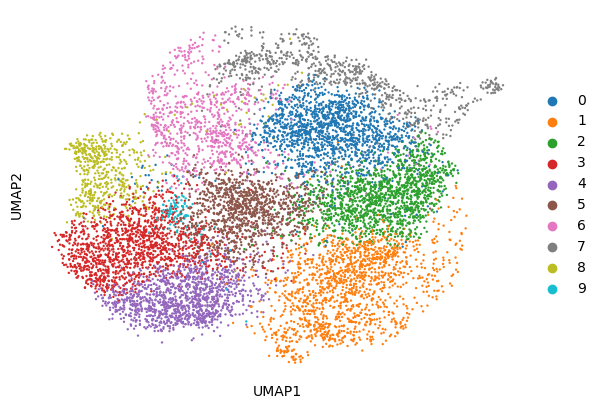

In [73]:
plt.figure(figsize=(5,4))
sc.pl.umap(d, color='leiden', show=False)
plt.gca().spines[:].set_visible(False)
plt.title('')
plt.savefig('../_supp/fig.RA.umap_with_clusters.png', dpi=500)
plt.show()

## case-ctrl analysis of patch clusters with avg expression representation

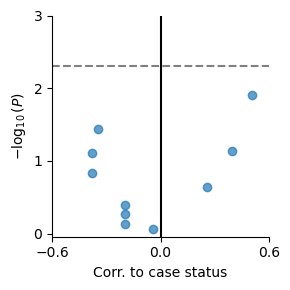

In [16]:
plt.figure(figsize=(3,3))
volcano(plt.gca(), '_results/patchwideavgs_clustertest.csv')
plt.tight_layout()
plt.savefig('../_supp/fig.RA.volcano_clusteredpatchavgs.png', dpi=500)
plt.show()

## marker differences

In [16]:
def style_violinplot(ax):
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, title=None)
    ax.set_ylabel('Avg. normalized intensity')
    ax.set_yticks([-2, 0, 2, 4])
    ax.set_xlabel('')
    ax.spines[['right','top']].set_visible(False)

In [17]:
Mdense.numpy_mode()
mavg = pd.DataFrame(Mdense[:][0].mean(axis=(1,2)), index=d.obs.index, columns=markers)
mavg.shape

data augmentation is off
in numpy mode


(10345, 7)

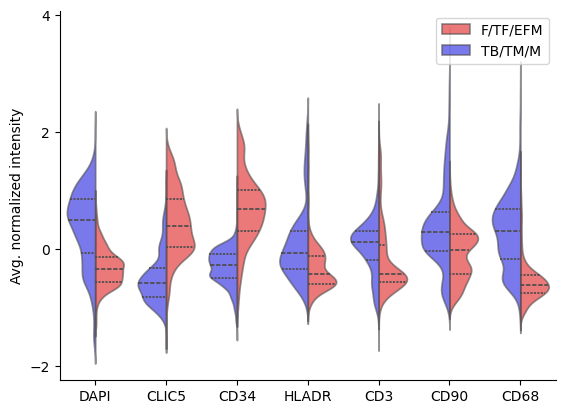

In [79]:
pos = d.obs.ncorr_thresh > 0
neg = d.obs.ncorr_thresh < 0
vv.diff_markers(mavg,
                    d.obs[pos].index, d.obs[neg].index, mavg.columns, sort=False,
                    labels=['F/TF/EFM','TB/TM/M'], nmarkers=len(mavg.columns),
                    split=True, inner='quart', density_norm='count', alpha=0.6,
                    ax=plt.gca(), show=False,
                    palette={'F/TF/EFM':'red', 'TB/TM/M':'blue'}
                    )
style_violinplot(plt.gca())
plt.savefig('../_supp/fig.RA.casectrl_markerdiff.png', dpi=500)
plt.show()

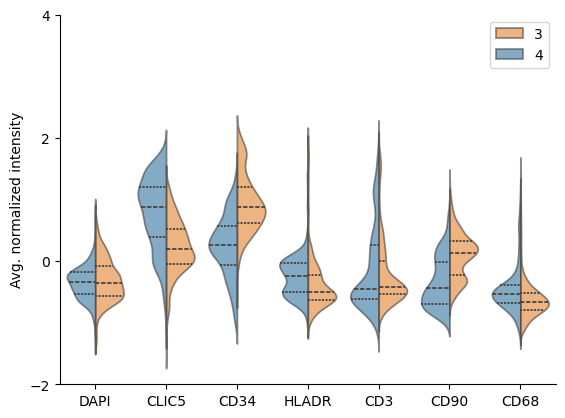

In [18]:
pos = d.obs.pos_leiden == '0'
neg = d.obs.pos_leiden == '1'
vv.diff_markers(mavg,
                    d.obs[pos].index, d.obs[neg].index, mavg.columns, sort=False,
                    labels=['3','4'], nmarkers=len(mavg.columns),
                    split=True, inner='quart', density_norm='count', alpha=0.6,
                    ax=plt.gca(), show=False,
                    )
style_violinplot(plt.gca())
plt.savefig('../_supp/fig.RA.clusts3vs4_markerdiff.png', dpi=500)
plt.show()

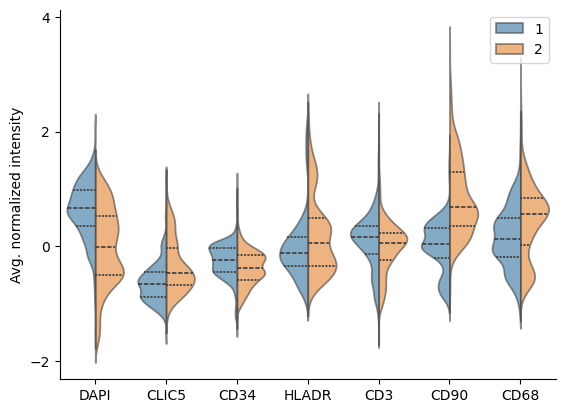

In [19]:
pos = d.obs.neg_leiden == '0'
neg = d.obs.neg_leiden == '1'
vv.diff_markers(mavg,
                    d.obs[pos].index, d.obs[neg].index, mavg.columns, sort=False,
                    labels=['1','2'], nmarkers=len(mavg.columns),
                    split=True, inner='quart', density_norm='count', alpha=0.6,
                    ax=plt.gca(), show=False,
                    )
style_violinplot(plt.gca())
plt.savefig('../_supp/fig.RA.clusts1vs2_markerdiff.png', dpi=500)
plt.show()

## CTAP enrichments among positive patches


log odds ratios for cluster 3 within pos patches
          LOR  CI_lower  CI_upper
EFM  0.517244  0.140192  0.894296
F   -0.015487 -0.325318  0.294344
M    1.373117  0.840938  1.905297
TB   0.208068 -0.250642  0.666778
TF  -0.606967 -0.948937 -0.264997
TM  -2.349322 -3.331905 -1.366739


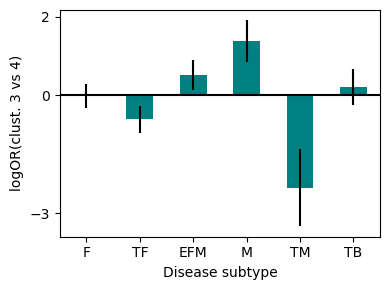

In [20]:
plt.figure(figsize=(4,3))
enrichment(plt.gca(), 'pos', 'pos0', [-3,0,2], 3, ctaporder=['F','TF','EFM','M','TM','TB'])
plt.tight_layout()
plt.savefig('../_supp/fig.RA.clusts3vs4_ctapenrichment.png', dpi=500)
plt.show()